# XGBoost for Cancellation Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, f1_score
from category_encoders import TargetEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## Dataset import

In [2]:
data = pd.read_parquet("../../data/hotel_booking_optimized.parquet")
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119389 entries, 0 to 119388
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119389 non-null  category      
 1   is_canceled                     119389 non-null  int8          
 2   lead_time                       119389 non-null  int16         
 3   arrival_date_year               119389 non-null  int16         
 4   arrival_date_month              119389 non-null  category      
 5   arrival_date_week_number        119389 non-null  int8          
 6   arrival_date_day_of_month       119389 non-null  int8          
 7   stays_in_weekend_nights         119389 non-null  int8          
 8   stays_in_week_nights            119389 non-null  int8          
 9   adults                          119389 non-null  int16         
 10  children                        119389 non-null  int8   

We can confirm hereby that the memory usage has successfully been brought under 50MB, which is good.

## Features

We first need to decide what columns will be relevant for training this model.

Let's first see if there are any differences in cancellation rates between our two hotels.

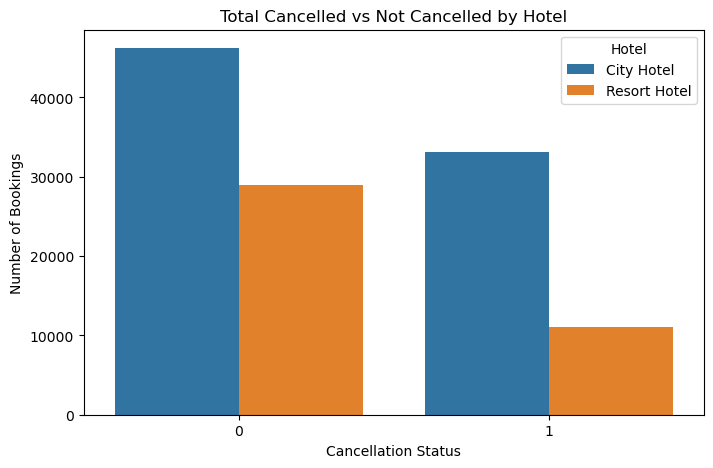

In [3]:
# total cancelled vs not cancelled by hotel
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x="is_canceled", hue="hotel")
plt.title("Total Cancelled vs Not Cancelled by Hotel")
plt.xlabel("Cancellation Status")
plt.ylabel("Number of Bookings")
plt.legend(title="Hotel")
plt.show();

In [4]:
data.groupby("hotel", observed=False)["is_canceled"].value_counts(normalize=True).unstack()

is_canceled,0,1
hotel,,
City Hotel,0.58273,0.41727
Resort Hotel,0.72236,0.27764


There are indeed some differences. Worth noting.

Now let's decide what to do with each of the columns.

In [5]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'],
      dtype='object')

In [6]:
# total columns

len(data.columns)

36

In [7]:
# Columns



# Drop columns based on relevance, sensitivity, and potential data leakage

# name -> irrelevant, sensitive
# email -> irrelevant, sensitive
# phone-number -> irrelevant, sensitive
# credit_card -> sensitive, not predictive
# reservation_status -> data leakage
# reservation_status_date -> potential data leakage
# assigned_room_type -> potential data leakage
# company -> high missing values (over 90% missing)
# reserved_room_type -> not suitable for prearrival prediction
# booking_changes -> not suitable for prearrival prediction


# one-hot encode categorical columns with low cardinality

# hotel -> two hotels, perfect for one-hot encoding
# meal -> few categories, suitable for one-hot encoding
# market_segment -> few categories, suitable for one-hot encoding
# distribution_channel -> few categories, suitable for one-hot encoding
# customer_type -> few categories, suitable for one-hot encoding
# deposit_type -> few categories, suitable for one-hot encoding
# arrival_date_month -> 12 months, suitable for one-hot encoding


# target encoding for high cardinality categorical columns

# agent -> high cardinality, target encoding preferred
# country -> high cardinality, target encoding preferred


# columns to leave numeric / passhthrough

# lead_time -> number of days before arrival, leave as is
# arrival_date_year -> year of arrival, leave as is
# arrival_date_week_number -> week number of arrival, leave as is
# arrival_date_day_of_month -> day of month of arrival, less predictive, but leave as is
# stays_in_weekend_nights -> number of weekend nights booked, leave as is
# stays_in_week_nights -> number of week nights booked, leave as is
# adults -> number of adults, leave as is
# children -> number of children, leave as is
# babies -> number of babies, leave as is
# previous_cancellations -> number of previous cancellations, leave as is
# previous_bookings_not_canceled -> number of previous non-canceled bookings, leave as is
# days_in_waiting_list -> number of days in waiting list, leave as is
# adr -> average daily rate, leave as is
# required_car_parking_spaces -> number of parking spaces required, leave as is
# total_of_special_requests -> number of special requests made, leave as is
# is_repeated_guest -> whether the guest is a repeat guest, leave as is


# target variable

# is_canceled

The missing values in agent and country should be handled with -1 before target encoding.

Let's explore some feature engineering ideas.

In [8]:
# total_stay = stays_in_weekend_nights + stays_in_week_nights
# adr_per_person = adr / (adults + children + babies)
# season/quarter based on arrival_date_month or arrival_date_week_number
# hotel * lead_time interaction
# hotel * agent interaction

Now let's double check if there is any significant imbalance between our two classes in the target variable.

In [9]:
data["is_canceled"].value_counts(normalize=True)

is_canceled
0    0.629581
1    0.370419
Name: proportion, dtype: float64

This is fine. We will optimize for roc_auc during and then look for an optimal f1 threshold later on.

## Pipeline

### Defining the columns (based on the commented decisions above)

In [10]:
# Columns for one-hot encoding (low-cardinality categorical)
onehot_cols = [
    "hotel", "meal", "market_segment", "distribution_channel",
    "customer_type", "deposit_type", "arrival_date_month"
]

# Columns for target encoding (high-cardinality categorical)
target_cols = ["agent", "country"]

# Numeric / passthrough columns
numeric_cols = [
    "lead_time", "arrival_date_year", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights", "stays_in_week_nights",
    "adults", "children", "babies", "previous_cancellations",
    "previous_bookings_not_canceled", "days_in_waiting_list",
    "adr", "required_car_parking_spaces", "total_of_special_requests",
    "is_repeated_guest"
]

# Unincluded columns will be dropped in the preprocessing step

### Preprocessing pipeline

In [11]:
# Target encoding for high-cardinality categorical features
target_encoder = TargetEncoder(cols=target_cols, smoothing=5)  # CV-safe inside pipeline

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("target", target_encoder, target_cols),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
        ("numeric", "passthrough", numeric_cols)
    ]
)

### Pipeline build

In [12]:
# XGBoost Classifier with GPU support inside a Pipeline - will need an appropriate GPU setup
# Here, RTX 5070 Ti will be used

pipeline = Pipeline([
    # preprocessing step
    ("preprocessing", preprocessor),

    # model step
    ("model", XGBClassifier(
        tree_method="hist",
        # Use GPU
        device="cuda",

        # Basic hyperparameters, will be overridden in hyperparameter tuning
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric="logloss"
    ))
])

### Train/test split

In [13]:
X = data.drop("is_canceled", axis=1)
y = data["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Useful method for f1 search later on

In [14]:
def optimal_f1_search(y_true, y_probs):
    
    thresholds = np.linspace(0,1,101)
    f1_scores = []

    for t in thresholds:
        y_pred_thresh = (y_probs >= t).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_thresh))

    best_idx = np.argmax(f1_scores)
    print("Best threshold:", thresholds[best_idx])
    print("Best F1:", f1_scores[best_idx])

    plt.plot(thresholds, f1_scores)
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Decision Threshold")
    plt.show()

## Naive model for reference

In [15]:
untuned_xgb_pipeline = pipeline.fit(X_train, y_train)
untuned_xgb_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
y_pred_train = untuned_xgb_pipeline.predict(X_train)
y_pred_test = untuned_xgb_pipeline.predict(X_test)

c:\Users\Sebastijan\anaconda3\envs\hotel_management\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:07:19] WARNING: D:\bld\xgboost-split_1744329000128\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#### Naive model evaluation

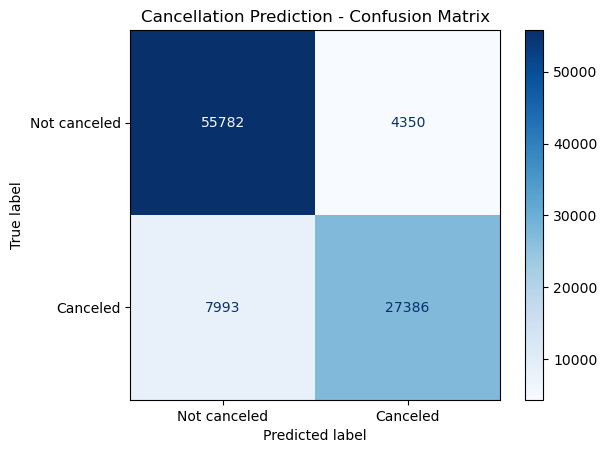

              precision    recall  f1-score   support

Not canceled       0.87      0.93      0.90     60132
    Canceled       0.86      0.77      0.82     35379

    accuracy                           0.87     95511
   macro avg       0.87      0.85      0.86     95511
weighted avg       0.87      0.87      0.87     95511



In [17]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None  # can also do 'true' to normalize by row
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

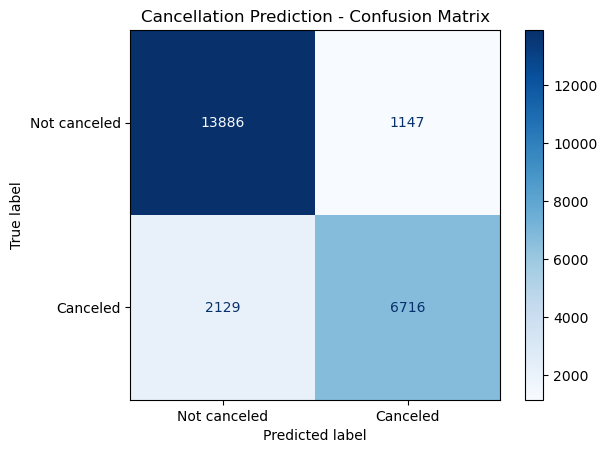

              precision    recall  f1-score   support

Not canceled       0.87      0.92      0.89     15033
    Canceled       0.85      0.76      0.80      8845

    accuracy                           0.86     23878
   macro avg       0.86      0.84      0.85     23878
weighted avg       0.86      0.86      0.86     23878



In [18]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

ROC-AUC: 0.9389660929486315


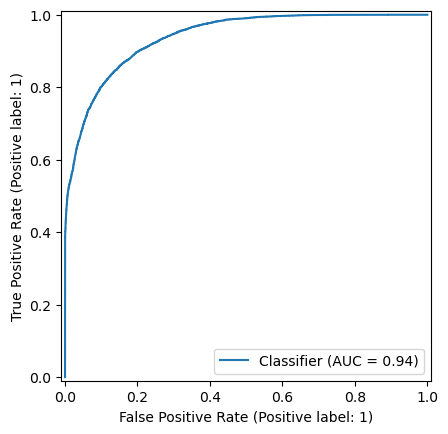

In [19]:
y_probs = untuned_xgb_pipeline.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

In [20]:
feature_names = untuned_xgb_pipeline.named_steps["preprocessing"].get_feature_names_out()
untuned_xgb_model = untuned_xgb_pipeline.named_steps['model']
importances = untuned_xgb_model.feature_importances_

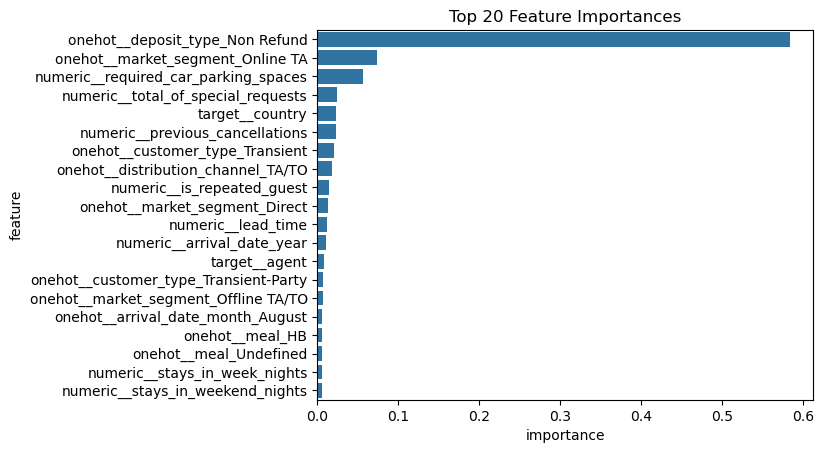

In [21]:
df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances")
plt.show();

In [22]:
irrelevant_features = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).loc[importances == 0]

irrelevant_features

,feature,importance
3,onehot__hotel_Resort Hotel,0.0
16,onehot__market_segment_Undefined,0.0
21,onehot__distribution_channel_Undefined,0.0
28,onehot__deposit_type_Refundable,0.0


## First model with hyperparameter tuning

In [ ]:
param_dist = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [4, 6, 8, 10],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__gamma": [0, 1, 5]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=1, # Use 1 to avoid potential GPU conflicts
    random_state=42
)

random_search.fit(X_train, y_train)

tuned_xgb_pipeline = random_search.best_estimator_
tuned_xgb_pipeline

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=500, model__subsample=1.0; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=500, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=500, model__subsample=1.0; total time=   1.3s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=200, model__subsample=0.8; total time=   0.5s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=200, model__subsample=0.8; total time=   0.5s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.05, model__max_depth=4, mod

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_pred_train = tuned_xgb_pipeline.predict(X_train)
y_pred_test = tuned_xgb_pipeline.predict(X_test)

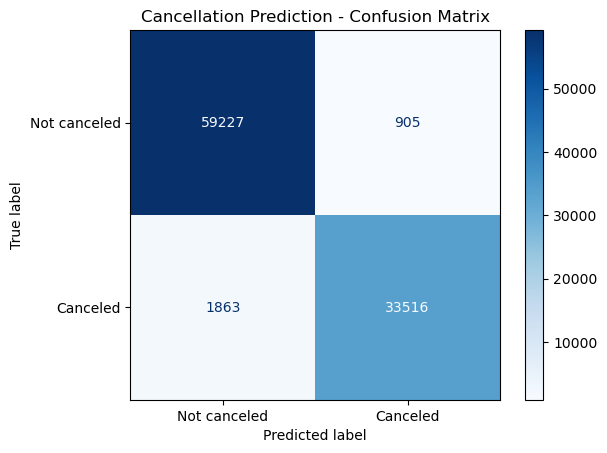

              precision    recall  f1-score   support

Not canceled       0.97      0.98      0.98     60132
    Canceled       0.97      0.95      0.96     35379

    accuracy                           0.97     95511
   macro avg       0.97      0.97      0.97     95511
weighted avg       0.97      0.97      0.97     95511



In [26]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None  # can also do 'true' to normalize by row
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

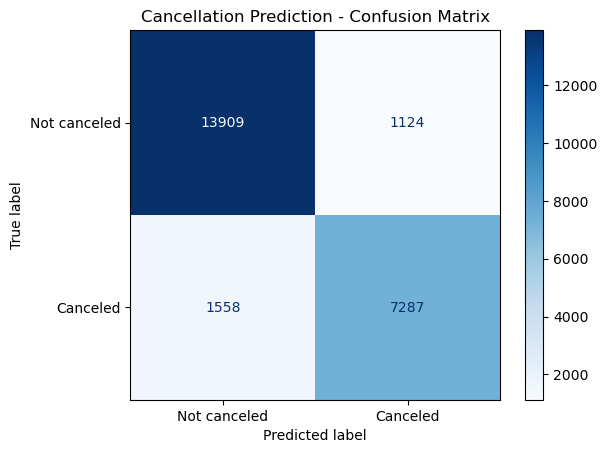

              precision    recall  f1-score   support

Not canceled       0.90      0.93      0.91     15033
    Canceled       0.87      0.82      0.84      8845

    accuracy                           0.89     23878
   macro avg       0.88      0.87      0.88     23878
weighted avg       0.89      0.89      0.89     23878



In [27]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

In [29]:
random_search.best_params_

{'model__subsample': 1.0,
 'model__n_estimators': 400,
 'model__max_depth': 10,
 'model__learning_rate': 0.2,
 'model__gamma': 0,
 'model__colsample_bytree': 0.8}

ROC-AUC: 0.955492880802615


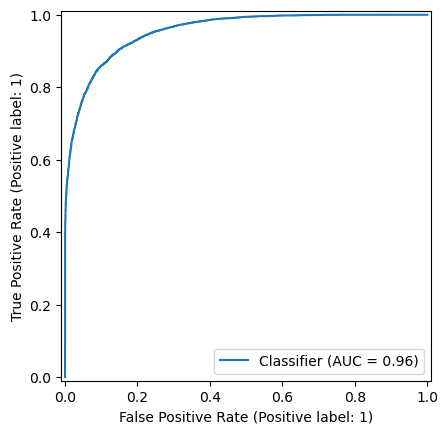

In [30]:
y_probs = tuned_xgb_pipeline.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

The model is better, but there is some overfitting.

## Second model with hyperparameter tuning

Let's add some parameters meant to deal with the overfitting.

In [31]:
param_dist_2 = {
    "model__n_estimators": [300, 500, 700],
    
    # Shallower trees to avoid overfitting
    "model__max_depth": [3, 4, 6],

    # Lower learning rate so trees are less aggressive
    "model__learning_rate": [0.01, 0.05, 0.1],

    # Regularization
    "model__min_child_weight": [3, 5, 10],
    "model__gamma": [0, 1, 5],

    # Subsampling to prevent memorization
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],

    # L1/L2 regularization
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [1, 2, 5],
}

random_search_2 = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_2,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=1, # Use 1 to avoid potential GPU conflicts
    random_state=42
)

random_search_2.fit(X_train, y_train)

tuned_xgb_pipeline_2 = random_search_2.best_estimator_
tuned_xgb_pipeline_2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.7; total time=   0.8s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.7; total time=   0.9s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.7; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.05, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=1.0; total time=   0.8s

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
y_pred_train = tuned_xgb_pipeline_2.predict(X_train)
y_pred_test = tuned_xgb_pipeline_2.predict(X_test)

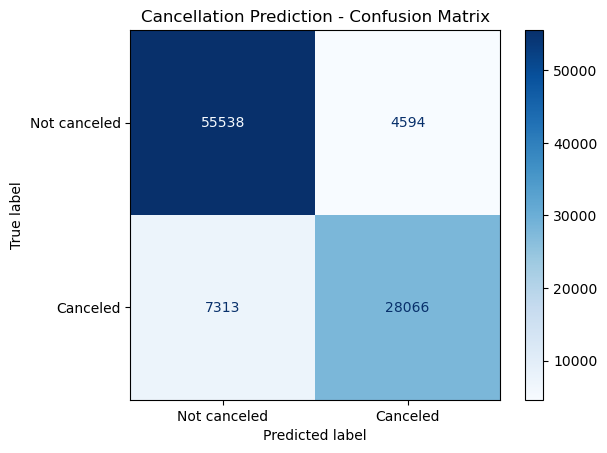

              precision    recall  f1-score   support

Not canceled       0.88      0.92      0.90     60132
    Canceled       0.86      0.79      0.82     35379

    accuracy                           0.88     95511
   macro avg       0.87      0.86      0.86     95511
weighted avg       0.87      0.88      0.87     95511



In [33]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None  # can also do 'true' to normalize by row
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

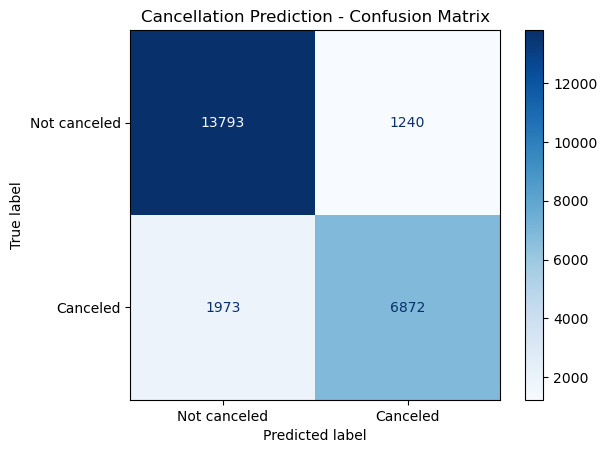

              precision    recall  f1-score   support

Not canceled       0.87      0.92      0.90     15033
    Canceled       0.85      0.78      0.81      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.85      0.85     23878
weighted avg       0.86      0.87      0.86     23878



In [34]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

In [35]:
random_search_2.best_params_

{'model__subsample': 0.7,
 'model__reg_lambda': 5,
 'model__reg_alpha': 0,
 'model__n_estimators': 700,
 'model__min_child_weight': 3,
 'model__max_depth': 4,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.8}

ROC-AUC: 0.9424827053743494


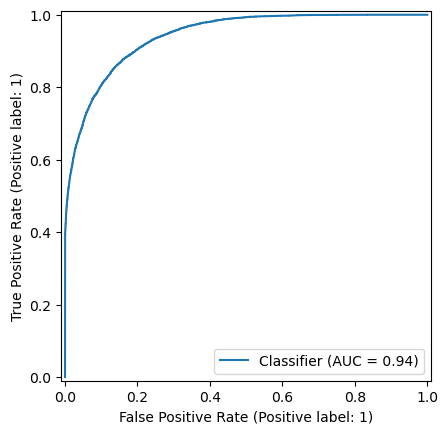

In [36]:
y_probs = tuned_xgb_pipeline_2.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

Let's quickly check the best f1.

Best threshold: 0.39
Best F1: 0.8186386976947448


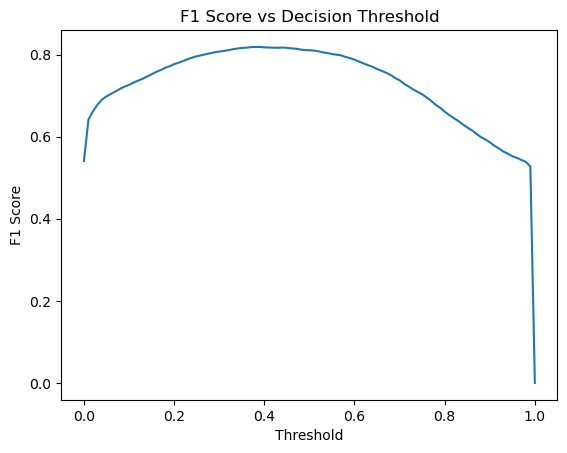

In [37]:
optimal_f1_search(y_test, y_probs)

Now let's just check if the feature importances are roughly similar across models.

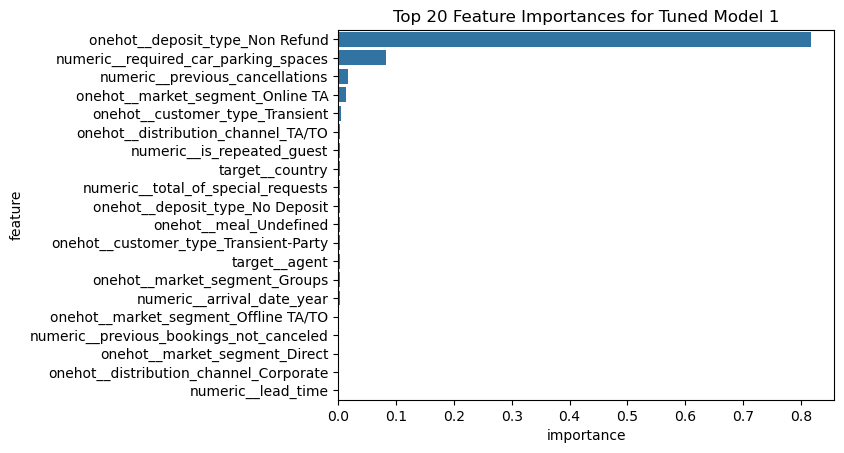

In [43]:
feature_names = tuned_xgb_pipeline.named_steps["preprocessing"].get_feature_names_out()
tuned_xgb_model_1 = tuned_xgb_pipeline.named_steps['model']
importances = tuned_xgb_model_1.feature_importances_

df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances for Tuned Model 1")
plt.show();

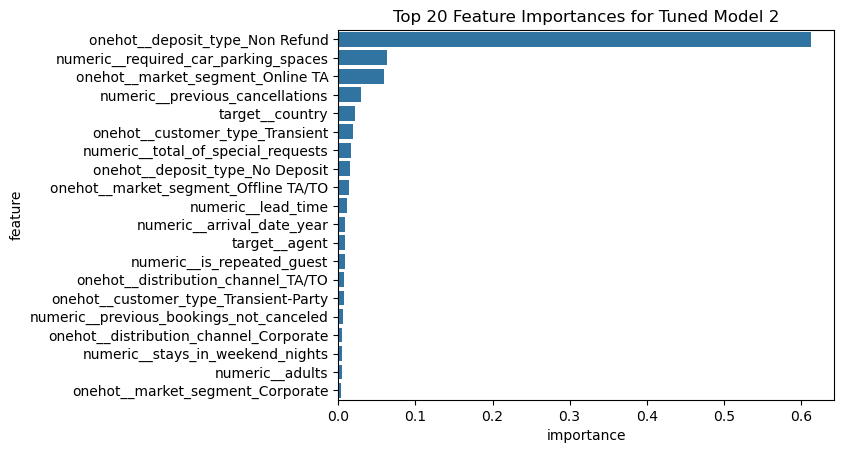

In [44]:
feature_names = tuned_xgb_pipeline_2.named_steps["preprocessing"].get_feature_names_out()
tuned_xgb_model_2 = tuned_xgb_pipeline_2.named_steps['model']
importances = tuned_xgb_model_2.feature_importances_

df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances for Tuned Model 2")
plt.show();